<a href="https://colab.research.google.com/github/arturoduar/detection/blob/main/testers/ImageClothingPropertyClassifier_TFHub_basic_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main Skeleton Tester - *Tensoflow Hub* Image Detector Pattern**

This script illustrates the basic skeleton of the extraction of an item's feature (color) from an image that contains the item. The basic logic is:

For each image: 
- Detect where in the image the item is located by producing a detection box (sub-image) that contains the best representation of the item.
- Crop the image to isolate the item, then process the sub-image with feature ckassifiers. In this first attempt, we try to estract the best color that matches the item. 

Script Parts Sequence:

1. Imports
2. Load detectors / classifiers / add restrictions
  - In this TF Hub-based script, we can use Inception_Resnet_V2, or Mobilenet V2 (lesser accuracy, but faster). Both are trained from the Openimages V4 dataset. The detection restriction we add is to only keep results from the 'Clothing' branch of the dataset. 
  - The color classifier is a K-Means model from SciKit Learn, that is then matched via minimum RGB distance to our own list of available detailed colors.    
3. Load data file
  - This is a file with the same format as the one used to submit data to SAP Upscale, with columns for 'asin' and the ssociated image URLs
4. Process a chosen image:

  a. import image from URL

  b. reshape image to match detector input

  c. detect from the image possible item boxes

  d. use a criteria for selecting the box that best captures the item we want to examine
  - In this tester, we use the highest scored item from a list that is common to all of them (intersection)

  e. crop the image to isolate the item.

  f. analyze the sub-image with the classifies (color in this case)
  - The color is picked from the highest scored color among all images 



In [1]:
!pip install webcolors  # may not be really needed

In [2]:
# 1. imports

# Tensorflow
import tensorflow as tf
# For running inference on the TF-Hub module for the inception model 
import tensorflow_hub as hub

# main working imports
import pandas as pd
import json
import os
#import gzip
import subprocess
import numpy as np
#from datetime import datetime
import requests
#import bs4

# imnporting, displaying, and drawing into images imports
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import cv2 as cv

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 
from google.colab.patches import cv2_imshow
import webcolors 
import os


In [3]:
# 2.a
# load image detection module - models from Tensorflow Hub:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

# TF Hub uses the pattern below to evaluate pre-processed images 
# i.e. given a valid input image 'my_image', run the detector simply like this:
#   result = detector('my_image')
detector = hub.load(module_handle).signatures['default']

# define the classes that are admissible (in this case, under the main class 'Clothing' from OpenInages V4)
class_inclusion_set = set(["/m/07qxg_", "/m/03p3bw", "/m/080hkjn", "/m/0584n8", "/m/01s55n", 
                           "/m/01940j", "/m/0zvk5", "/m/0hf58v5", "/m/0h8mhzd", "/m/03nfch",
                           "/m/06k2mb", "/m/01b638", "/m/02p3w7d", "/m/09j5n", "/m/0fly7",
                           "/m/07mhn", "/m/04tn4x", "/m/0nl46", "/m/0jyfg", "/m/0hnnb", "/m/0gjkl",
                           "/m/080hkjn", "/m/02h19r", "/m/02wbtzl", "/m/02jfl0", "/m/02fq_6", "/m/025rp__",
                           "/m/02dl1y", "/m/02_n6y", "/m/01rkbr", "/m/01r546", "/m/01nq26", "/m/01llwg",
                           "/m/01krhy", "/m/017ftj", "/m/0176mf", "/m/03grzl", "/m/0174n1", "/m/0463sg",
                           "/m/032b3c", "/m/01cmb2", "/m/02wv6h6", "/m/02h19r", "/m/02wbtzl", "/m/02jfl0",
                           "/m/02fq_6", "/m/025rp__", "/m/02dl1y", "/m/01xyhv", "/m/01xygc", "/m/01n4qj",
                           "/m/01krhy", "/m/01gmv2", "/m/01gkx_", "/m/01d40f", "/m/01bfm9"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
# 2.b
# Color detection using K-Means 

kmeans = KMeans(n_clusters=4)

HEX_TO_NORMALIZED_NAMES = {
    "#f5f5dc": "beige",
    "#000000": "black",
    "#0000ff": "blue",
    "#a52a2a": "brown",
    "#808080": "gray",
    "#808080": "grey",
    "#008000": "green",
    "#ffa500": "orange",
    "#ffc0cb": "pink",
    "#800080": "purple",
    "#ff0000": "red",
    "#ffffff": "white",
    "#ffff00": "yellow",
}

def closest_color(requested_color):
    min_colors = {}
    #for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
    for key, name in HEX_TO_NORMALIZED_NAMES.items():  
      r_c, g_c, b_c = webcolors.hex_to_rgb(key)
      rd = (r_c - requested_color[0]) ** 2
      gd = (g_c - requested_color[1]) ** 2
      bd = (b_c - requested_color[2]) ** 2
      min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def get_color_name(requested_color):
    try:
      closest_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
      closest_name = closest_color(requested_color)
    return closest_name

def detect_color(img_path):
  img = cv2.imread(img_path)
  height, width, dim = img.shape
  img = img[int(height/4):int(3*height/4), int(width/4):int(3*width/4), :]
  height, width, dim = img.shape
    
  img_vec = np.reshape(img, [height * width, dim] )
    
  #kmeans = KMeans(n_clusters=4)
  kmeans.fit( img_vec )

  unique_l, counts_l = np.unique(kmeans.labels_, return_counts=True)
  sort_ix = np.argsort(counts_l)
  sort_ix = sort_ix[::-1]

  cluster_center = kmeans.cluster_centers_[sort_ix][0]

  # return cluster_center
  
  return get_color_name((int(cluster_center[2]), int(cluster_center[1]), int(cluster_center[0])))

In [5]:
# 3
# Read the data to be examined (csv)
df_img_data = pd.read_csv("ImagesToExamine.csv") 

df_img_data.head

<bound method NDFrame.head of           asin             category_tags  ... avg_customer_reviews response
0   B00062NHH0                breadcrumb  ...   3.9 out of 5 stars      200
1   B0190LOMCQ                    search  ...   4.5 out of 5 stars      200
2   B00HV713ME       search | department  ...   4.3 out of 5 stars      200
3   B00N1SZXSM                    search  ...   3.5 out of 5 stars      200
4   B01HEISONU         breadcrumb | rank  ...   4.5 out of 5 stars      200
5   B018K0X9RC                    search  ...   3.0 out of 5 stars      200
6   B01D866GUU                    search  ...                  NaN      200
7   B00O4UYXC8                      rank  ...   4.5 out of 5 stars      200
8   B00DR4918S                    search  ...   3.5 out of 5 stars      200
9   B00FPFBCFW                    search  ...   4.0 out of 5 stars      200
10  B009MQO432  breadcrumb | rank | rank  ...   3.6 out of 5 stars      200
11  B00LUHJJUE                    search  ...   3.4 out of

In [7]:
# add a column to collect analysis
df_img_data["img_feature_analysis"] = ""
#list(df_img_data)

In [8]:
# Main detection helper functions
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_box(winner, path, image, boxes, class_names, scores, max_boxes=1, min_score=0.5):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  print('winner = ' + winner)

  lidx = np.where(class_names == winner.encode("ascii"))
  nidx = lidx[0]
  idx = nidx[np.argmax(scores[nidx])] 
  #print('idx = ' + str(idx))
  #print(class_names[idx].decode("ascii"))
  score = scores[idx]
  ymin, xmin, ymax, xmax = tuple(boxes[idx])
  display_str = "{}: {}%".format(class_names[idx].decode("ascii"),
                                int(100 * scores[idx]))
  color = colors[hash(class_names[idx]) % len(colors)]
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
  draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
  np.copyto(image, np.array(image_pil))
  im_width, im_height = image.shape[:2]
  #print("im: " +  str(im_width) + ',      ' + str(im_height))
  cropped, croped_path = crop_image(path, xmin, ymin, xmax, ymax, im_width, im_height)

  im_width, im_height = image.shape[:2]

  return image, cropped, display_str, score

def crop_image(path, xmin, ymin, xmax, ymax, im_width, im_height):
    myImage = cv.imread(str(path))
    # print("path: " + str(path))
    # print("cords: " + str(xmin) + ', ' + str(ymin) + ', '  + str(xmax) + ', '   + str(ymax))
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                                      ymin * im_height, ymax *im_height)
    myImage = cv.resize(myImage,(im_width,im_height))
    cropped = myImage[int(top): int(bottom), int(left):int(right)]
    cv.imwrite("img_cropped.jpg", cropped)
    croped_path = "img_cropped.jpg"
    # print(croped_path)
    return cropped, croped_path

In [14]:
# 4
# Process Images

main_results = {}

# main function to add features to a row of input data
def add_img_features(in_params):
  out_params = in_params 

  # 4.a Make a list of image urls
  image_urls = in_params[6].split('|')
  print(image_urls)

  img_feature_analysis = {}
  patterns = set()
  colors = set()

  for image_url in image_urls:
    print(image_url)
    image_path = download_and_resize_image(image_url, 640, 640)
    plt.imshow(load_img(image_path))
    plt.show()

    print(image_path)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # 4.b Pre-process image
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    #start_time = time.time()
    # 4.c Use the Object Detector on processed image
    result = detector(converted_img)
    #end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    main_results[image_url] = result

  # form a set with all the common, relevant images
  detect_intersection = set([])
  for image in main_results:
    #print(image)
    cleaned_list = []
    for ithclass in main_results[image]['detection_class_names']:
      if ithclass.decode("ascii").lower() in class_inclusion_set: 
        cleaned_list.append(True)
      else:
        cleaned_list.append(False)  

    running_set = set(main_results[image]['detection_class_entities'][cleaned_list])
    if len(detect_intersection) == 0:
      detect_intersection = running_set
    else:
      detect_intersection = detect_intersection.intersection(running_set)  

    # print(main_results[image]['detection_class_entities'][cleaned_list])
    # print(set(main_results[image]['detection_class_entities'][cleaned_list]))  
  print(detect_intersection)

  # 4.d
  # Get the scores for the common items
  item_scores = {}
  item_winner = {}
  for item in detect_intersection:
    scores = []
    for image in main_results:
      idx = np.where(main_results[image]['detection_class_entities'] == item)
      # print(idx)
      scores = np.concatenate((scores, main_results[image]['detection_scores'][idx]), axis=0)
      # scores.append(main_results[image]['detection_scores'][idx]) 

    avg_score = np.average(scores)
    item_scores[item.decode("ascii")] = avg_score
    if item_winner == {}:
      item_winner[item.decode("ascii")] = avg_score
      item_winner_label = item.decode("ascii")
    else:
      if avg_score > list(item_winner.values())[0]:
        item_winner = {}
        item_winner[item.decode("ascii")] = avg_score 
        item_winner_label = item.decode("ascii")

  image_colors = {}
  for image_url in image_urls:
    print(image_url)
    # image_path = download_and_resize_image(image_url, 640, 480)
    image_path = download_and_resize_image(image_url, 640, 640)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    #print("Found %d objects." % len(main_results[image_url]["detection_scores"]))
    #print("Inference time: ", end_time-start_time)
    #print(result)

    # 4.e
    # Crop the image 
    image_with_boxes, cropped_img, display_str, winner_score = draw_box(item_winner_label, image_path,
      img.numpy(), main_results[image_url]["detection_boxes"],
      main_results[image_url]["detection_class_entities"], main_results[image_url]["detection_scores"])
    
    plt.imshow(image_with_boxes)
    plt.show()

    print('cropped. Class: ' + display_str)
    plt.imshow(cropped_img)
    plt.show()
    #cropped_img = load_img("img_cropped.jpg", target_size = (64, 64))
    cropped_img = img_to_array(cropped_img)
    cropped_img = np.expand_dims(cropped_img, axis = 0)

    # 4.f
    # Run the cropped image through the particular feature classifiers (in this 
    # script there is only one classifier - color)
    prediction_color = detect_color("img_cropped.jpg")
    colors.add(str(prediction_color))
    image_colors[winner_score] = str(prediction_color)

    print('predicted color: ' + str(prediction_color))

  print(image_colors)
  main_color = image_colors[min(image_colors.keys())]

  if len(colors) != 0:
    #img_feature_analysis['colors'] = list(colors)  
    img_feature_analysis['colors'] = main_color

  out_json = json.dumps(img_feature_analysis)
  out_params[17] = out_json

  return out_params
  

In [15]:
sample = df_img_data.loc[df_img_data['asin'] == 'B00N1SZXSM'].values.flatten().tolist()
# sample = df_img_data.loc[df_img_data['asin'] == 'B00HV713ME'].values.flatten().tolist()
# sample = df_img_data.loc[df_img_data['asin'] == 'B00DR4918S'].values.flatten().tolist()


In [16]:
sample[4]

'Womens Retro Vintage Chiffon Polka Dot Lapel Long Sleeve Shirt Blouse Tops E456'

['https://images-na.ssl-images-amazon.com/images/I/61uEZKLYwrL.jpg ', ' https://images-na.ssl-images-amazon.com/images/I/61lW4mLvywL.jpg ', ' https://images-na.ssl-images-amazon.com/images/I/51SJZAbTR5L.jpg ', ' https://images-na.ssl-images-amazon.com/images/I/51lHpuH7rEL.jpg ', ' https://images-na.ssl-images-amazon.com/images/I/51e%2BAXI27RL.jpg ', ' https://images-na.ssl-images-amazon.com/images/I/61qZoN9SiWL.jpg']
https://images-na.ssl-images-amazon.com/images/I/61uEZKLYwrL.jpg 
Image downloaded to /tmp/tmp5konfvep.jpg.


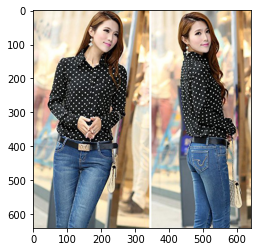

/tmp/tmp5konfvep.jpg
 https://images-na.ssl-images-amazon.com/images/I/61lW4mLvywL.jpg 
Image downloaded to /tmp/tmpz03k7hpc.jpg.


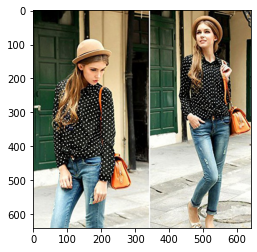

/tmp/tmpz03k7hpc.jpg
 https://images-na.ssl-images-amazon.com/images/I/51SJZAbTR5L.jpg 
Image downloaded to /tmp/tmpryd2u8w_.jpg.


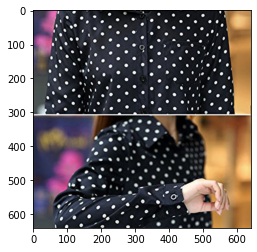

/tmp/tmpryd2u8w_.jpg
 https://images-na.ssl-images-amazon.com/images/I/51lHpuH7rEL.jpg 
Image downloaded to /tmp/tmply9dr6f5.jpg.


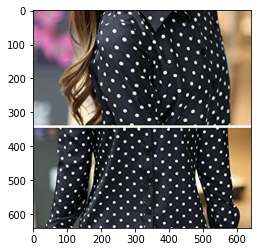

/tmp/tmply9dr6f5.jpg
 https://images-na.ssl-images-amazon.com/images/I/51e%2BAXI27RL.jpg 
Image downloaded to /tmp/tmpab65va_e.jpg.


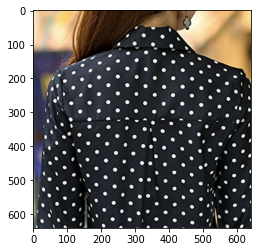

/tmp/tmpab65va_e.jpg
 https://images-na.ssl-images-amazon.com/images/I/61qZoN9SiWL.jpg
Image downloaded to /tmp/tmpmjmb7xhl.jpg.


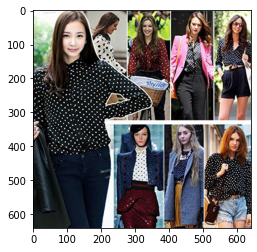

/tmp/tmpmjmb7xhl.jpg
{b'Dress', b'Jacket', b'Shirt', b'Suit', b'Coat'}
https://images-na.ssl-images-amazon.com/images/I/61uEZKLYwrL.jpg 
Image downloaded to /tmp/tmpflvya6o6.jpg.
winner = Suit


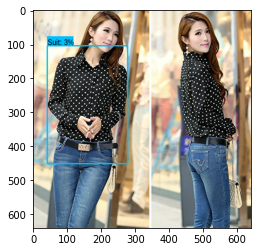

cropped. Class: Suit: 3%


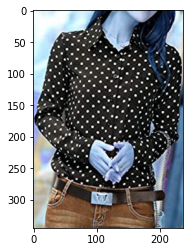

predicted color: black
 https://images-na.ssl-images-amazon.com/images/I/61lW4mLvywL.jpg 
Image downloaded to /tmp/tmprmm_odv8.jpg.
winner = Suit


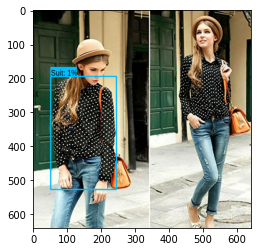

cropped. Class: Suit: 1%


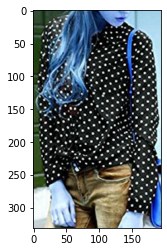

predicted color: black
 https://images-na.ssl-images-amazon.com/images/I/51SJZAbTR5L.jpg 
Image downloaded to /tmp/tmppvrwfh3k.jpg.
winner = Suit


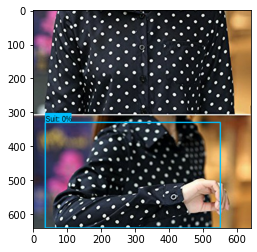

cropped. Class: Suit: 0%


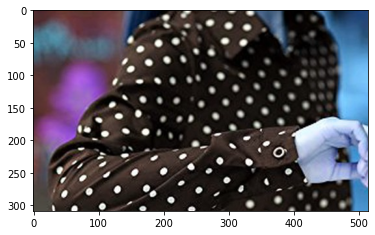

predicted color: black
 https://images-na.ssl-images-amazon.com/images/I/51lHpuH7rEL.jpg 
Image downloaded to /tmp/tmp0om6vorz.jpg.
winner = Suit


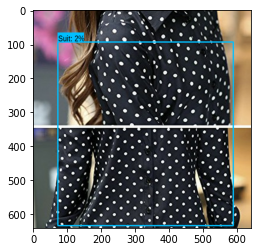

cropped. Class: Suit: 2%


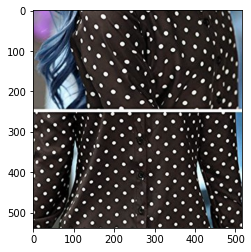

predicted color: black
 https://images-na.ssl-images-amazon.com/images/I/51e%2BAXI27RL.jpg 
Image downloaded to /tmp/tmp9fnmwyo6.jpg.
winner = Suit


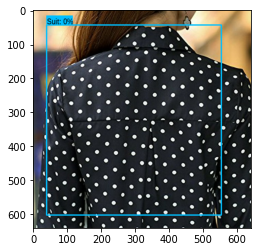

cropped. Class: Suit: 0%


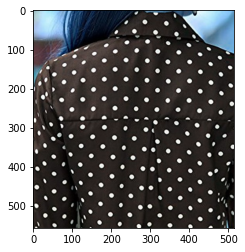

predicted color: black
 https://images-na.ssl-images-amazon.com/images/I/61qZoN9SiWL.jpg
Image downloaded to /tmp/tmpmt7js6u8.jpg.
winner = Suit


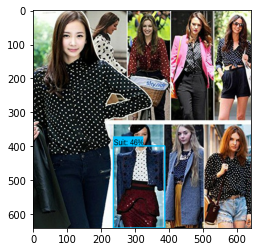

cropped. Class: Suit: 46%


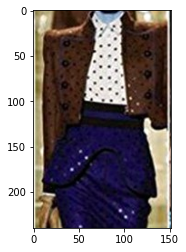

predicted color: black
{0.0391252: 'black', 0.01396121: 'black', 0.0062096156: 'black', 0.025792103: 'black', 0.0066289473: 'black', 0.4681727: 'black'}


In [17]:
sampleresult = add_img_features(sample)

In [18]:
sampleresult[17]

'{"colors": "black"}'